In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (30, 8)
mpl.rcParams['axes.grid'] = True
from evaluation import forecast_accuracy

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_pickle('../dataset/preprocessed/48_imputed.pkl')

print(df.isna().sum())
print(df.dtypes)

DOA         0
DBA         0
LAR      5040
ADR      4950
Rooms       0
ROH         0
dtype: int64
DOA       object
DBA      float64
LAR      float64
ADR      float64
Rooms    float64
ROH      float64
dtype: object


In [3]:
def preprocess(dx, cutoff = [0, 1, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]):
    dx['DOA'] = pd.to_datetime(dx['DOA'])
    dx = dx.replace([np.inf, -np.inf], np.nan)

    # @impute: if available room = 0 set it to maximum
    dx.loc[dx['Rooms']==0,'Rooms'] = dx['Rooms'].max()
    # @normalize: over booking to maximum number of rooms 
    dx.loc[dx['ROH']>dx['Rooms'],'ROH'] = dx['Rooms'].max()
    dx['DOA'] = pd.to_datetime(dx['DOA'])
    dx['DBA'] = 89 - dx['DBA']
    dx = dx[dx.DBA.isin(cutoff)]
    dx['OCC'] = dx['ROH']/dx['Rooms']

    # DBA as attributes 
    dx = dx.pivot(index='DOA', columns='DBA', values='OCC')
    # Removing sub index from Dataframe
    dx = dx.rename_axis(None, axis = 0)
    cols = {col:'ROH'+str(int(col+1)).zfill(2) for col in dx.columns }

    # renaming columns
    dx = dx.rename(columns=cols)
    dx = dx.rename(columns={'ROH01':'ROH'})

    # reversing the sequance of attributes
    return dx.sort_index(axis=1 ,ascending=False)

def train_test_split(dx):
    index = int(len(dx)*0.8)
    train = dx[:index]
    test  = dx[index:]
    return train,test

def plot_train_test(train, test):
    plt.plot(train.index, train['ROH'], label='Train')
    plt.plot(test.index, test['ROH'], label='Test')
    plt.xlabel('DOA')
    plt.ylabel('ROH')
    plt.legend(loc='best')
    plt.show()

def plot_result(dx):
    plt.plot(dx.index, dx['ROH'], label='test')
    plt.plot(dx.index, dx['PRED'], linestyle='--', color='#ff7823', label="Predicted")
    plt.xlabel('Day of Arrival (DOA)')
    plt.ylabel('Reservations on Hand (ROH)')
    plt.title("Random Forest Regressor (RMSE={})".format(0.0095))
    plt.legend(loc='best')
    plt.show()

In [4]:
data = preprocess(df,[0, 20, 29, 59, 89])
train,test = train_test_split(data)
train.head(10)

DBA,ROH90,ROH60,ROH30,ROH21,ROH
2018-01-01,0.019608,0.160000,0.440000,0.590909,0.860465
2018-01-02,0.217391,0.340909,0.386364,0.522727,0.906977
2018-01-03,0.260870,0.340909,0.386364,0.545455,0.906977
2018-01-04,0.152174,0.227273,0.318182,0.431818,0.860465
2018-01-05,0.108696,0.181818,0.295455,0.318182,0.813953
2018-01-06,0.043478,0.431818,0.428571,0.448980,0.674419
2018-01-07,0.021739,0.022727,0.045455,0.090909,0.277778
2018-01-08,0.043478,0.068182,0.159091,0.232558,0.812500
2018-01-09,0.043478,0.068182,0.181818,0.255814,0.941176
2018-01-10,0.021739,0.045455,0.136364,0.325581,0.974359


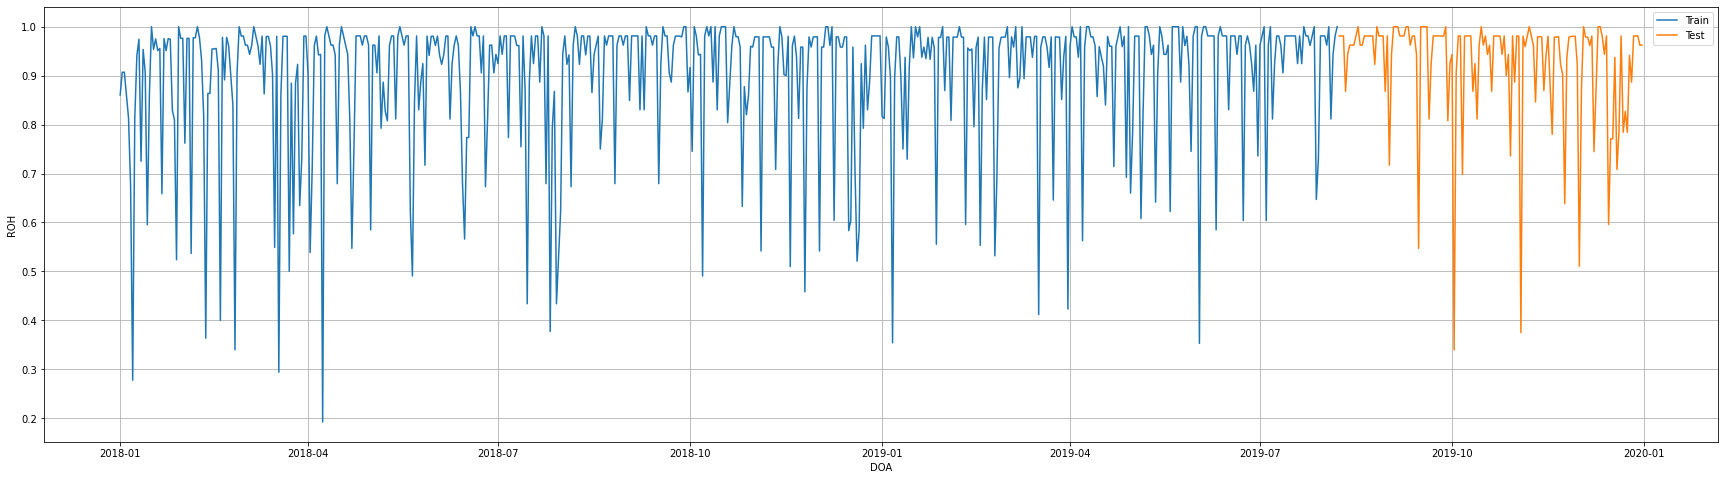

In [5]:
plot_train_test(train,test)

## Model Selection

In [6]:
y = train.pop('ROH')
X = train

In [7]:
regr = RandomForestRegressor(max_depth=1000, random_state=0)
regr.fit(X, y)

RandomForestRegressor(max_depth=1000, random_state=0)

In [8]:
test_predict_cols = [attr for attr in test.columns if attr!='ROH']
test['PRED']  = regr.predict(test[test_predict_cols])

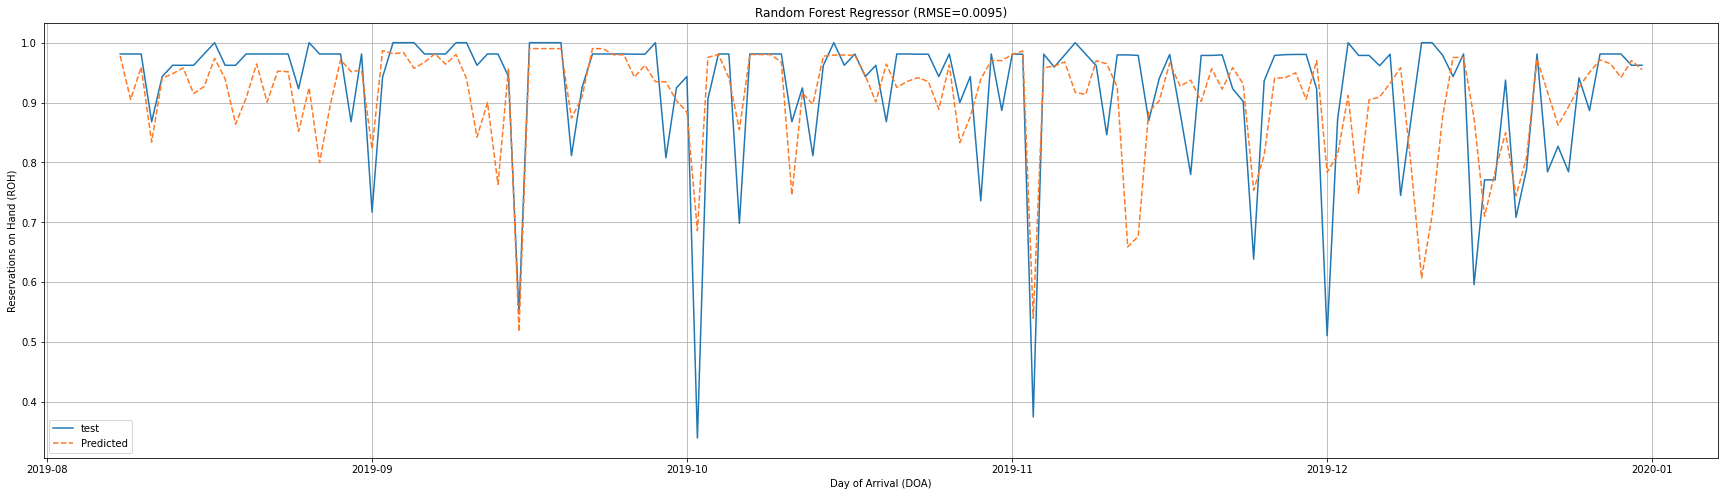

In [9]:
plot_result(test)

In [23]:
# # test.rename(columns={"PRED":"RFR"})[['RFR']]
# # df = pd.read_csv('../dataset/results.csv')
# df['RFR'] = test.rename(columns={"PRED":"RFR"})[['RFR']].values
# df.to_csv('../dataset/results.csv')


In [10]:
forecast_accuracy(test['PRED'],test['ROH'])

0.0962	&	0.0027	&	0.0629	&	7.8277	&	0.0973	&	0.0095	&	0.2643


In [16]:
# Get numerical feature importances
importances = list(regr.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(test.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: ROH02                Importance: 0.8572
Variable: ROH03                Importance: 0.0432
Variable: ROH04                Importance: 0.0089
Variable: ROH30                Importance: 0.0077
Variable: ROH60                Importance: 0.0074
Variable: Day                  Importance: 0.0073
Variable: LAR                  Importance: 0.006
Variable: ROH05                Importance: 0.0054
Variable: ROH21                Importance: 0.005
Variable: ROH90                Importance: 0.0043
Variable: Mon                  Importance: 0.0042
Variable: ROH06                Importance: 0.004
Variable: ROH14                Importance: 0.0038
Variable: ROH07                Importance: 0.0037
Variable: LAR90                Importance: 0.0035
Variable: Week_SUN             Importance: 0.0034
Variable: LAR02                Importance: 0.0031
Variable: LAR07                Importance: 0.0025
Variable: LAR30                Importance: 0.0022
Variable: LAR60                Importance: 0.0022
Var

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## With attributes

In [11]:
def preprocess(dx, cutoff = [0, 1, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]):
    dx['DOA'] = pd.to_datetime(dx['DOA'])
    dx = dx.replace([np.inf, -np.inf], np.nan)
    dx = dx[~dx['LAR'].isna()]
    # @impute: if available room = 0 set it to maximum
    dx.loc[dx['Rooms']==0,'Rooms'] = dx['Rooms'].max()
    # @normalize: over booking to maximum number of rooms 
    dx.loc[dx['ROH']>dx['Rooms'],'ROH'] = dx['Rooms'].max()
    dx['DOA'] = pd.to_datetime(dx['DOA'])
    dx['DBA'] = 89 - dx['DBA']
    dx = dx[dx.DBA.isin(cutoff)]
    dx['OCC'] = dx['ROH']/dx['Rooms']

    # DBA as attributes 
    occ = dx.pivot(index='DOA', columns='DBA', values='OCC')
    # Removing sub index from Dataframe
    occ = occ.rename_axis(None, axis = 0)
    cols = {col:'ROH'+str(int(col+1)).zfill(2) for col in occ.columns }
    # renaming columns
    occ = occ.rename(columns=cols)
    occ = occ.rename(columns={'ROH01':'ROH'}).sort_index(axis=1 ,ascending=False)

    # DBA as attributes 
    lar = dx.pivot(index='DOA', columns='DBA', values='LAR')
    # Removing sub index from Dataframe
    lar = lar.rename_axis(None, axis = 0)
    cols = {col:'LAR'+str(int(col+1)).zfill(2) for col in lar.columns }
    # renaming columns
    lar = lar.rename(columns=cols)
    lar = lar.rename(columns={'LAR01':'LAR'})

    lar['DOW'] = lar.index.dayofweek
    lar['Mon'] = lar.index.month
    lar['Day'] = lar.index.day
    # # standardizing prices
    # scaler = StandardScaler()
    # lar[lar.columns] = scaler.fit_transform(lar[lar.columns])
    # onehot encoding day of week 
    enc = OneHotEncoder(handle_unknown='ignore')
    lar[['Week_MON','Week_TUE','Week_WED','Week_THR','Week_FRI','Week_SAT','Week_SUN']] = enc.fit_transform(lar['DOW'].values.reshape(-1, 1)).toarray()
    lar = lar.drop(columns=['DOW'])

    dx = pd.concat([lar, occ],axis=1)
    # reversing the sequance of attributes
    return dx

# Combined results

In [12]:
cuttoffs = [1, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]
clean_hotels = [  48,   80,   86,  148,  151,  199,  269,  284,  317,  322,  577,1041, 1100, 1479, 1968, 4290]
for i in range(0,len(cuttoffs)):
    print('- DBA ',i)
    print([0]+cuttoffs[i:])
    for hotelId in clean_hotels:
        df = pd.read_pickle('../dataset/preprocessed/'+str(hotelId)+'_imputed.pkl')
        df = preprocess(df,[0]+cuttoffs[i:])
        train, test = train_test_split(df)
        cols = [col for col in df.columns if col != 'ROH']
        # creating model 
        y = train.pop('ROH')
        X = train
        # grid search best params
        regr = RandomForestRegressor(max_depth=2, random_state=0)
        regr.fit(X, y)
        # grids.best_params_
        # print(grids.best_estimator_)
        # predict with best parameter
        test['PRED'] = regr.predict(test[cols])
        # plot 
        # plot_result(test)    
        # evaluation
        forecast_accuracy(test['PRED'],test['ROH'])

- DBA  0
[0, 1, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]
0.0442	&	0.0129	&	0.0335	&	3.9296	&	0.0465	&	0.0022	&	0.841
0.0432	&	-0.0112	&	0.0347	&	4.1816	&	0.0436	&	0.0019	&	0.8654
0.0785	&	-0.0889	&	0.0633	&	12.585	&	0.0853	&	0.0073	&	0.847
0.0553	&	-0.0235	&	0.0465	&	7.2244	&	0.056	&	0.0031	&	0.9163
0.0372	&	-0.0037	&	0.0266	&	3.2901	&	0.0372	&	0.0014	&	0.8886
0.2488	&	-inf	&	0.1218	&	inf	&	0.2602	&	0.0677	&	0.0413
0.0416	&	0.0101	&	0.0305	&	3.5475	&	0.0432	&	0.0019	&	0.8552
0.0343	&	-0.0065	&	0.0232	&	2.8944	&	0.0343	&	0.0012	&	0.88
0.0468	&	-0.0098	&	0.0326	&	3.889	&	0.0471	&	0.0022	&	0.7535
0.0334	&	-0.0069	&	0.0269	&	3.1468	&	0.0336	&	0.0011	&	0.8687
0.0484	&	0.0099	&	0.0399	&	6.093	&	0.0494	&	0.0024	&	0.9466
0.0225	&	0.0005	&	0.0176	&	2.119	&	0.0226	&	0.0005	&	0.854
0.0334	&	-0.0084	&	0.0261	&	2.9657	&	0.0339	&	0.0011	&	0.8275
0.0352	&	0.0039	&	0.0285	&	3.3469	&	0.0356	&	0.0013	&	0.9234
0.0432	&	-0.0054	&	0.0357	&	4.7236	&	0.0432	&	0.0019	&	0.9242
0.0438	&	0.0113	&	0.0326	&	3.8344	&	0.0

KeyboardInterrupt: 